# Identify Missing ID

Author: Olatomiwa Bifarin<br>
Department of Biochemistry and Molecular Biology<br>
University of Georgia<br>
Edison Lab<br>

Last edited: 28JAN2020 

_This is a static version of a Jupyter notebook, and work (documentation) is still in progress_ 

**Goals**: 
1. To merge NMR and MS Dataset. 

<a id="0"></a>

## Notebook Content

1.  [RCC Prediction in Model Cohort](#1)
2.  [RCC Prediction: Test Cohort](#2)
3.  [Chemical Information of Biomarkers](#3)


## Dataframes
-  The original form of the MS data from the Facundo Lab at Georgia tech is uploaded as the `dfMS` dataframe.
-  `MS-Labels` is the dataframe for Mass Spectrometry detected metabolites IDs, mode, retention time and formula
-  `MS` is the dataframe for the MS Peak Intensities
-  `MSData` is the dataframe for `all` the MS Peak Intensities with patient ID and Groups
-  `dfNMR` contains representative peaks for features/metabolites from NMR
-  `combined` is the NMR merged with the MS dataset. 
-  `combined_clinic` is the dataframe that contains all combined NMR and MS samples collected in the clinic. 
-  `PMdata`
-  `PMdata2`
-  `modelcohort`
-  `testcohort`
-  `qfeatures`
-  `MLfeatures??`
-  `MLfeatures2??`
-  `biomarker`
-  `biomarker2`
-  `MS_labels_bmarkers`
-  `MS_labels_qmarkers`

In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style
import scipy
#For Seaborn plots
import seaborn as sns; sns.set(style='white')
#To ignore warning
import warnings
warnings.filterwarnings('ignore')

# More sharp and legible graphics
%config InlineBackend.figure_format = 'retina'

# Set seaborn figure labels to 'talk', to be more visible. 
sns.set_context('talk', font_scale=0.8)

# 1. RCC Prediction in Model Cohort
<a id="1"></a>

In [14]:
# Set seaborn figure labels to 'talk', to be more visible. 
sns.set_context('talk', font_scale=0.8)
import statsmodels as sms
from statsmodels.stats import multitest
from statistics import mean

# Machine Learning Libraries
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier

# Import Random Forest classifier, sklearn metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# test train split and K-fold validation
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn import decomposition

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

# Plotly and Network Graph Libraries
import plotly as py
import plotly.graph_objs as go

import networkx as nx

py.offline.init_notebook_mode(connected=True)

#### Export Model Cohort Data

In [15]:
modelcohort = pd.read_excel('data/modelcohort.xlsx')

### a. Feature Selection 

### (i)  Select features with greater than 2-fold changes

Non-metabolic features in the `modelcohort` dataframe include the following: 
-  Sample ID
-  Patient ID
-  Collection
-  Gender
-  Race
-  BMI
-  Smoker
-  Age
-  Groups

In [16]:
NMRMS = modelcohort.drop(['Sample ID', 'Patient ID', 'Collection', 'Gender',
                         'Race', 'BMI', 'Smoker', 'Age'], axis=1)
Control = NMRMS[(NMRMS['Groups'] == 'Control')]
RCC = NMRMS[(NMRMS['Groups'] == 'RCC')]

dfmean = pd.DataFrame({'Features':NMRMS.drop(['Groups'], axis=1).mean(axis=0).index, 
                       'Control':Control.drop(['Groups'], axis=1).mean(axis=0).values,
                       'RCC':RCC.drop(['Groups'], axis=1).mean(axis=0).values})
dfmean.shape

(7145, 3)

In [17]:
cols = []
ctr_val = dfmean['Control']
rcc_val = dfmean['RCC']

for ctr, rcc in zip(ctr_val, rcc_val):
    ratio1 = ctr/rcc
    ratio2 = rcc/ctr
    if ratio1 > 2:
        feature = dfmean[dfmean['Control']==ctr]['Features'].values.tolist()
        cols.append(feature)
    elif ratio2 > 2:
        feature = dfmean[dfmean['Control']==ctr]['Features'].values.tolist()
        cols.append(feature)
xfold_feat = [val for sublist in cols for val in sublist] # flatten out list of list.
len(xfold_feat)

2104

### (ii) _t_-Test Feature Selection 

_T-Test Function_

In [18]:
def Ttest(metabolites, dfControl, dfTreat, alpha=0.05, var=True):
    '''
    Function conducts a T-test for the metabolites differences between two groups with 
    Benjamini-Hocberg FDR correction
    
    Inputs: 
    metabolites = A list containing names of metabolites
    dfControl = A pandas dataframe containing the control group metabolites data
    dfTreat =  A pandas dataframe containing the treatment group metabolites data
    alpha = alpha for statistical significant judgment, default 0.05
    var = If True (default), perform a standard independent 2 sample test that assumes 
    equal population variances [1]. If False, perform Welch’s t-test, which does not 
    assume equal population variance
    
    Outputs: A pandas dataframe with p-values of numerical cohort characteristics. 
    
    '''
    ttest_dict = {}
    for metabolite in metabolites:
        statistic, pvalue =  scipy.stats.ttest_ind(dfControl[metabolite], 
                                               dfTreat[metabolite], 
                                               equal_var=var)
        ttest_dict[metabolite] = pvalue 
        # a dictionary containing name of metabolites and p value after t-test
    ttest = pd.DataFrame.from_dict(ttest_dict, orient='index') # the dictionary in pandas df
    ttest_list=list(ttest_dict.values()) #values (pvalues) of ttest result in a list
    reject, pval_corrected, _, _ = sms.stats.multitest.multipletests(ttest_list, 
                                                                 alpha=alpha, 
                                                                 method='fdr_bh')
    ttest_results = pd.DataFrame({'Metabolite': metabolites, 'T-test p-value': ttest_list, 
                              'FDR p-value': pval_corrected, 'Reject H0': reject})
    Table = ttest_results.sort_values(by=['FDR p-value'])
    return Table

In [19]:
# '''List of final metabolites set'''
metabolite_list = xfold_feat

# '''List of final metabolites set'''
ttest_result = Ttest(metabolite_list, Control, RCC, alpha=0.05, var=True)

# '''List of Statistically relevant metabolites'''
# Select metabolites with <0.05 FDR
stat_sig = ttest_result.loc[ttest_result['Reject H0'] == True]

# Select metabolites with <0.05 t-test
#stat_sig = ttest_result.loc[ttest_result['T-test p-value'] <= 0.05]
print("The total number of significant metabolites/Features is: ", len(stat_sig))

The total number of significant metabolites/Features is:  435


In [20]:
Feature = stat_sig['Metabolite'].values.tolist(); # stat MS significant metabolites
qfeatures = NMRMS[Feature] # p<0.05 metabolites
#MLfeatures =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) #autoscaling

In [21]:
qfeatures.shape

(62, 435)

In [22]:
qfeatures.astype(float);

In [23]:
correlated_features = set()
correlation_matrix = qfeatures.astype(float).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [24]:
UNCfeatures = qfeatures.drop(correlated_features, axis=1)
UNCfeatures.shape

(62, 132)

### (iii). PLSRegression for Feature Selection

Reference: 
-  https://nirpyresearch.com/variable-selection-method-pls-python/
-  https://github.com/scikit-learn/scikit-learn/issues/7050
-  https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html

In [25]:
dfgrp = NMRMS.filter(['Groups'], axis=1)
# convert strings (RCC, Control) to integers
dfgroup = dfgrp['Groups'].map({'Control': 0, 'RCC': 1}) 
# Features and groups
X = UNCfeatures.values
y = dfgroup.values

In [26]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

In [27]:
pls = PLSRegression()
pls.fit(X, y)

PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

*PLS coefficient of the fit*

In [28]:
pls.coef_[:,0];

In [29]:
def vip(x, y, model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_

    m, p = x.shape
    _, h = t.shape

    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)

    return vips

In [30]:
vip_list = vip(X, y, pls.fit(X, y))

In [31]:
list_of_tuples = list(zip(UNCfeatures.columns, vip_list))
df_feat = pd.DataFrame(list_of_tuples, columns = ['Metabolites', 'Importance'])
df_feat = df_feat.sort_values(by='Importance', ascending=False)
#df_feat = df_feat.loc[df_feat['Ranking'] == True]
df_feat.head(20);

In [32]:
PLSfeatures = NMRMS[df_feat['Metabolites'][:20].tolist()] # top 20 ML PLS features

### (iv) Recursive Feature Elimination for Feature Selection

In [33]:
dfgrp = NMRMS.filter(['Groups'], axis=1)
# convert strings (RCC, Control) to integers
dfgroup = dfgrp['Groups'].map({'Control': 0, 'RCC': 1}) 
# Features and groups
X = UNCfeatures.values
y = dfgroup.values

Optimal number of features : 103


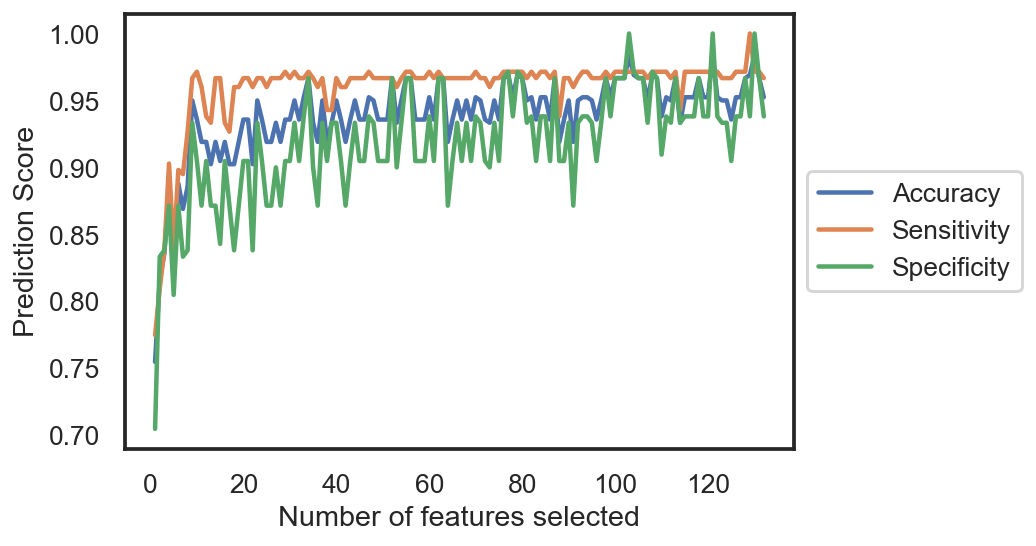

In [34]:
# Create the RFE object and compute a cross-validated score.
#RF= RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, class_weight="balanced",  random_state=42)
RF=RandomForestClassifier(n_estimators=100, random_state=42)


# Create a custom CV so we can seed with random state
rsk = model_selection.StratifiedKFold(n_splits=5, random_state=42)

# The "accuracy" scoring is proportional to the number of correct
# classifications
accuracy = RFECV(estimator=RF, cv=rsk, scoring='accuracy') #'accuracy'
precision = RFECV(estimator=RF, cv=rsk, scoring='precision') #'accuracy'
recall = RFECV(estimator=RF, cv=rsk, scoring='recall') #'accuracy'

accuracy.fit(X, y)
precision.fit(X, y)
recall.fit(X,y)

print("Optimal number of features : %d" % accuracy.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Prediction Score")
plt.plot(range(1, len(accuracy.grid_scores_) + 1), 
         accuracy.grid_scores_, label='Accuracy')
plt.plot(range(1, len(precision.grid_scores_) + 1), 
         precision.grid_scores_, label='Sensitivity')
plt.plot(range(1, len(recall.grid_scores_) + 1), 
         recall.grid_scores_, label='Specificity')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [35]:
print ("The highest accuracy features is {}%" .format(max(accuracy.grid_scores_)*100))

The highest accuracy features is 98.33333333333331%


Rank features by the features importance from `RF-RFECV` algorithms. 

In [36]:
list_of_tuples = list(zip(UNCfeatures.columns, 
                          accuracy.estimator_.feature_importances_, 
                          accuracy.support_, accuracy.ranking_))
df_feat = pd.DataFrame(list_of_tuples, columns = ['Metabolites', 'Importance', 
                                                  'Selected', 'Ranking'])
df_feat = df_feat.sort_values(by='Importance', ascending=False)
#df_feat = df_feat.loc[df_feat['Ranking'] == True]
df_feat.head(20)

,Metabolites,Importance,Selected,Ranking
1,3872,0.067131,True,1
2,3675,0.051305,True,1
66,2809,0.050428,False,25
5,4080,0.046002,True,1
58,2577,0.043519,True,1
4,6261,0.035327,True,1
7,3804,0.033225,True,1
11,3141,0.030105,True,1
0,2102,0.028605,True,1
61,5110,0.021525,False,26


_Select the features with the top 20 RF feature importance score or all features selected by the RFECV-RF_

In order to use the top features with the lowest q-values, use the the `stat_sig` dataframes

In [37]:
RFfeatures = NMRMS[df_feat['Metabolites'][:20].tolist()] # top 20 ML features
#MLfeatures = NMRMS[df_feat['Metabolites'].tolist()] # all selected features from RFECV-RF
#MLfeatures =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) #autoscaling

#### Converge the PLS-DA and RF features.

In [38]:
PLSfeatures.columns

Index([2102, 3872,  720, 3675, 4080, 6261, 6262, 3804,  819, 1701, 5887, 3141,
       1481, 6095, 2455, 3526,  278, 7087, 2850, 4766],
      dtype='object')

In [39]:
RFfeatures.columns

Index([3872, 3675, 2809, 4080, 2577, 6261, 3804, 3141, 2102, 5110, 3160, 1771,
       1481,  720, 6389, 5507, 2005, 6262, 6385, 4408],
      dtype='object')

In [40]:
final_features = set(PLSfeatures) - (set(PLSfeatures) - set(RFfeatures))

In [41]:
final_features

{720, 1481, 2102, 3141, 3675, 3804, 3872, 4080, 6261, 6262}

In [42]:
# Import MS_labels
MS_labels = pd.read_excel('data/MS_labels.xlsx')

In [43]:
MS_labels[MS_labels.ID.isin(final_features)]

,ID,Mode,RT [min],Name,Formula
719,720,positive,2.562,2-Aminoacetophenone;O-Acetylaniline,C8 H9 N O
1480,1481,positive,6.290,1481,NaN
2101,2102,positive,3.449,"N,N-Diisopropylethylamine (DIPEA)",C8 H19 N
3140,3141,positive,1.133,3141,C7 H18 N8 O6 S
3674,3675,positive,1.184,3675,NaN
3803,3804,positive,2.595,3804,C4 H12 N O6 P
3871,3872,positive,4.049,3872,NaN
4079,4080,positive,0.821,4080,C10 H21 N3 O8 P2 S
6260,6261,negative,2.591,6261,C9 H18 N9 O2 P
6261,6262,negative,2.667,6262,C10 H20 N9 O5 P


In [44]:
MLfeatures = NMRMS[list(final_features)]
MLfeatures =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) #autoscaling

# 3. Chemical Information of Biomarkers
<a id="3"></a>

In [48]:
MS_labels_qmarkers = MS_labels[MS_labels.ID.isin(qfeatures.columns)]
print(MS_labels_qmarkers.shape)
MS_labels_qmarkers.head()

(433, 5)


,ID,Mode,RT [min],Name,Formula
0,1,positive,2.317,1,NaN
8,9,positive,1.901,5-Acetylamino-6-amino-3-methyluracil,C7 H10 N4 O3
94,95,positive,1.898,"3-(1H-1,2,4-Triazol-3-yl)alanine",C5 H8 N4 O2
146,147,positive,2.580,147,C33 H41 N O6 P2
162,163,positive,2.654,Venlafaxine,C17 H27 N O2


MS_labels_bmarkers.to_excel('RCC_20features.xlsx')

MS_labels_qmarkers.to_excel('RCC_472features.xlsx')

# Confirm IDs with David

**Intersection of qfeatures**

In [49]:
gafeatures = pd.read_excel('RCC_472features.xlsx')

In [53]:
print (len(gafeatures['ID']))
print (len(MS_labels_qmarkers['ID']))

472
433


In [50]:
qmarker_int = list(set(gafeatures['ID']) & set(MS_labels_qmarkers['ID']))
print (len(qmarker_int))

418


**Intersection of UNCfeatures**

In [59]:
qmarker_int = list(set(UNCfeatures.columns) & set(gafeatures['ID']))
print (len(qmarker_int))

122


In [60]:
print (len(UNCfeatures.columns))
print (len(MS_labels_qmarkers['ID']))

132
433


features that were missing.

In [64]:
set(UNCfeatures.columns) - set(qmarker_int)

{1261, 2524, 2668, 3200, 4025, 5077, 5352, 6392, 6565, 6569}

In [65]:
MS_labels[MS_labels.ID.isin(set(UNCfeatures.columns) - set(qmarker_int))]

,ID,Mode,RT [min],Name,Formula
1260,1261,positive,1.855,1261,NaN
2523,2524,positive,1.299,2524,NaN
2667,2668,positive,1.067,Cyclo(leucylprolyl),C11 H18 N2 O2
3199,3200,positive,3.487,3200,NaN
4024,4025,positive,3.439,4025,C19 H29 N8 O3 P3
5076,5077,negative,1.965,5077,NaN
5351,5352,negative,2.355,5352,C34 H23 N O3
6391,6392,negative,0.750,6392,C7 H8 N4 O4
6564,6565,negative,2.935,6565,C12 H23 N O2 P2 S
6568,6569,negative,1.181,4-[(1R)-2-Amino-1-hydroxyethyl]-2-hydroxypheny...,C8 H11 N O6 S
